# Autoencoder und CNN gleichzeitig trainieren

**Disclamer:** Wir wollten den Autoencoder und das CNN gleichzeitig trainieren um das Ergebnis zu verbessern. Leider hat es nicht gut funktioniert und deshalb haben wir den Ansatz verworfen. Wir wollten jedoch trotzdem das Notebook abgeben, da trotzdem ein wenig Zeit reingeflossen ist.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam

#### Daten einlesen

**Hinweis:** Die Daten wurden in einer pkl-Datei gespeichert, um nicht jedes mal die Vorverarbeitung durchführen zu müssen und unkompliziert zwischen den Modelklassen hin- und her wechseln zu können

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size
X, y = data['data'], data['Species']
# Wir hatten massive Probleme mit der Begrenztheit unseres RAMs, weshalb wir versucht haben die Usage an mehreren Stellen zu reduzieren
X, y = np.stack(X).astype(np.float16), y.to_numpy().astype(np.uint8)


#### GPU deaktivieren

**Hinweis:** Bei M1/M2-Chips wird standardmäßig die GPU verwendet. Daher muss es für diese Chips einkommentiert werden, da diese Dropout-Layer mit GPU nicht gut handeln können

In [ ]:
#tf.config.set_visible_devices([], 'GPU')

#### Seed setzen

Um die Nachvollziehbarkeit zu erhöhen setzen wir den Seed immer auf den selben Startwert

In [ ]:
tf.keras.utils.set_random_seed(1)

Bei Verwendung einer GPU macht es die Operationen so deterministisch wie möglich

**Hinweis:** Diese Option vermindert die Performance

In [ ]:
tf.config.experimental.enable_op_determinism()

#### k-Fold-Cross-Validation

Wir benutzen 10-Fold-Cross-Validation, um das Ergebnis weniger vom gewählten Split abhängig zu machen und somit das Ergebnis zu stabilisieren. Statified stellt sicher, dass die Klasseneinteilung pro Split beibehalten wird. Dies ist vor allem ohne Resampling interessant, da wir extrem ungleich verteilte Klassen haben.

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

#### Bilder reshapen

In [3]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # Shape der Bilder nach dem resizen aus dem data_prep notebook
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c'])

In [4]:
X = X.reshape((-1,) + image_shape)
print(f"Image has shape: {image_shape}")

Image has shape: (82, 128, 3)


In [6]:
def train_val_test_split(train_indezes, test_indezes, tensor=False):
    X_train, X_val, y_train, y_val = train_test_split(X[train_indezes], y[train_indezes], test_size=0.2,stratify=y[train_indezes], random_state=42)
    X_test, y_test = X[test_indezes], y[test_indezes]
    # Das speichern als Tensor spart RAM (Wir haben hier die Option damit wir einfacher Noise drauflegen können)
    if tensor:
        return (tf.convert_to_tensor(X_train),
                tf.convert_to_tensor(y_train), 
                tf.convert_to_tensor(X_val),
                tf.convert_to_tensor(y_val),
                tf.convert_to_tensor(X_test),
                tf.convert_to_tensor(y_test))
    else:
        return (X_train,y_train,X_val,y_val,X_test,y_test)

#### Autoencoder erstellen

Ist der Gleiche wie in der data_prep-Datei

In [ ]:
epochs = 200
batch_size = 32

filter_sizes = [32,32,32,32,32,1]

def create_autoencoder_model():
    input = tf.keras.layers.Input(shape=image_shape, name="ae_input")
    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    x = tf.keras.layers.Cropping2D(((1,1),(0,0)))(x)
    
    # Autoencoder
    autoencoder = tf.keras.Model(input, x, name="autoencoder")
    return autoencoder


#### CNN erstellen

Ist das Gleiche wie in der cnn-Datei

In [9]:
# Stoppt wenn bei 30 Epochen die Validation-Accuracy nicht um mehr als 0.001 besser wird
early_stopping = EarlyStopping(monitor='val_cnn_f1_m', patience=30, min_delta=0.01, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.4
weight_decay_alpha = 0.01

def create_cnn_model():
    model = tf.keras.models.Sequential(name="cnn")
    model.add(tf.keras.layers.Input(shape=image_shape, name="cnn_input"))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

#### Modell

In [10]:
def create_combined_model(autoencoder_model, cnn_model):
    # Eingabe für beide Modelle
    autoencoder_input = tf.keras.layers.Input(shape=image_shape, name="main_input")


    # Autoencoder-Modell aufrufen und Ausgabe erhalten
    autoencoder_output = autoencoder_model(autoencoder_input)

    # CNN-Modell aufrufen und Ausgabe erhalten
    cnn_output = cnn_model(autoencoder_output)
    
    # Gemeinsames Modell erstellen
    combined_model = tf.keras.Model(inputs=[autoencoder_input], outputs=[autoencoder_output, cnn_output], name="combined_model")

    return combined_model

#### Model Fit Funktion

In [11]:
def fit_model(model, X_train, y_train, X_val=None, y_val=None):
    # Das Model macht selbst den Validation Split
    if X_val is None or y_val is None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_split=0.2,
            verbose=1)
    # Wir übergeben dem Model Validation Daten
    elif X_val is not None and y_val is not None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_data=(X_val,y_val),
            verbose=1)
    return history

In [12]:
cnn_model = create_cnn_model()
autoencoder_model = create_autoencoder_model(False)
combined_model = create_combined_model(autoencoder_model, cnn_model)

2024-01-19 11:16:36.929404: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-19 11:16:36.929430: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-19 11:16:36.929439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-19 11:16:36.929477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 11:16:36.929493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Noise

In [13]:
def add_salt_and_pepper_noise(image, noise_ratio=0.2):
    noise_iamge = image.copy()
    h, w, c = noise_iamge.shape
    noisy_pixels = int(h * w * noise_ratio)
 
    for _ in range(noisy_pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() < 0.5:
            noise_iamge[row, col] = [0, 0, 0] 
        else:
            noise_iamge[row, col] = [255, 255, 255]
 
    return np.clip((noise_iamge).astype(np.float16), 0, 1)

#### Tatsächliches Training

In [14]:
# Abspeichern der Erebnisse jedes Splits für die Confusion-Matrix
true_labels = list()
pred_labels = list()
train_accuracies_cnn = list()
train_accuracies_ae = list()
test_accuracies_cnn = list()
val_accuracies_cnn = list()
test_accuracies_ae = list()
val_accuracies_ae = list()
train_losses_cnn = list()
train_losses_ae = list()
val_losses_cnn = list()
test_losses_cnn = list()
val_losses_ae = list()
test_losses_ae = list()

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

for train_indezes, test_indezes in kfold.split(X, y):
    # wir löschen das Model der letzten Iteration aus dem Cache um RAM zu sparen
    K.clear_session()

    # Daten splitten
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(train_indezes, test_indezes)

    X_train_noise = np.asarray([add_salt_and_pepper_noise(image) for image in X_train])

    # Resample nur Trainings- und Validationmenge
    #X_train, y_train = resample_after_split(X_train, y_train)
    #X_val, y_val = resample_after_split(X_val, y_val)

    # Das Model wird hier compiled, damit wir nach jeder Iteration das alte Model aus dem Cache löschen können
    combined_model.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['mse', f1_m])
    history = combined_model.fit({"main_input":X_train_noise}, [X_train, y_train], epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val, [X_val, y_val]), callbacks=[early_stopping])
    #history = fit_model(combined_model, X_train, y_train, X_val, y_val)

    # Für die Confusion Matrix
    pred = combined_model.predict({"main_input":X_test})
    # pred[1] ist nur die Prediction vom CNN
    predictions = np.argmax(pred[1], axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # Für die Accuracy-Curves
    train_accuracies_cnn.extend(history.history['cnn_f1_m'])
    val_accuracies_cnn.extend(history.history['val_cnn_f1_m'])
    train_accuracies_ae.extend(history.history['autoencoder_f1_m'])
    val_accuracies_ae.extend(history.history['val_autoencoder_f1_m'])

    # Für die Loss-Curves
    train_losses_cnn.extend(history.history['cnn_loss'])
    val_losses_cnn.extend(history.history['val_cnn_loss'])
    train_losses_ae.extend(history.history['autoencoder_loss'])
    val_losses_ae.extend(history.history['val_autoencoder_loss'])

    score = combined_model.evaluate({"main_input":X_test}, [X_test,y_test])
    test_accuracies_cnn.append(score[6])
    test_losses_cnn.append(score[2])
    test_accuracies_ae.append(score[4])
    test_losses_ae.append(score[1])

(1488, 82, 128, 3)
(1488,)
(1488, 82, 128, 3)
(1861, 82, 128, 3)
(1861,)
(373, 82, 128, 3)
(373,)
Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 82, 128, 3)]      0         
                                                                 
 autoencoder (Functional)    (None, 82, 128, 3)        75651     
                                                                 
 cnn (Sequential)            (None, 6)                 6044550   
                                                                 
Total params: 6120201 (23.35 MB)
Trainable params: 6115337 (23.33 MB)
Non-trainable params: 4864 (19.00 KB)
_________________________________________________________________
None
Epoch 1/200


2024-01-19 11:16:49.354548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 10s 151ms/step - loss: 19.2576 - autoencoder_loss: 0.6841 - cnn_loss: 1.6915 - autoencoder_mse: 0.0778 - autoencoder_f1_m: 7.4147e-04 - cnn_mse: 2.4346 - cnn_f1_m: 1.2426 - val_loss: 9.6962 - val_autoencoder_loss: 0.6706 - val_cnn_loss: 1.8041 - val_autoencoder_mse: 0.0712 - val_autoencoder_f1_m: 6.6485e-04 - val_cnn_mse: 2.3854 - val_cnn_f1_m: 2.5701
Epoch 2/200
47/47 [==============================] - 5s 113ms/step - loss: 7.0481 - autoencoder_loss: 0.6052 - cnn_loss: 1.5190 - autoencoder_mse: 0.0407 - autoencoder_f1_m: 0.0019 - cnn_mse: 2.4313 - cnn_f1_m: 1.3810 - val_loss: 5.4989 - val_autoencoder_loss: 0.5941 - val_cnn_loss: 1.5231 - val_autoencoder_mse: 0.0356 - val_autoencoder_f1_m: 9.2782e-04 - val_cnn_mse: 2.3879 - val_cnn_f1_m: 3.1216
Epoch 3/200
47/47 [==============================] - 5s 116ms/step - loss: 4.6671 - autoencoder_loss: 0.5693 - cnn_loss: 1.4442 - autoencoder_mse: 0.0259 - autoencoder_f1_m: 1.6650e-04 - cnn_mse: 2.4328 -

#### Confusion Matrix

Man sieht dass das Model nicht wirklich was lernt, sondern einfach immer die größten Klassen vorhersagt

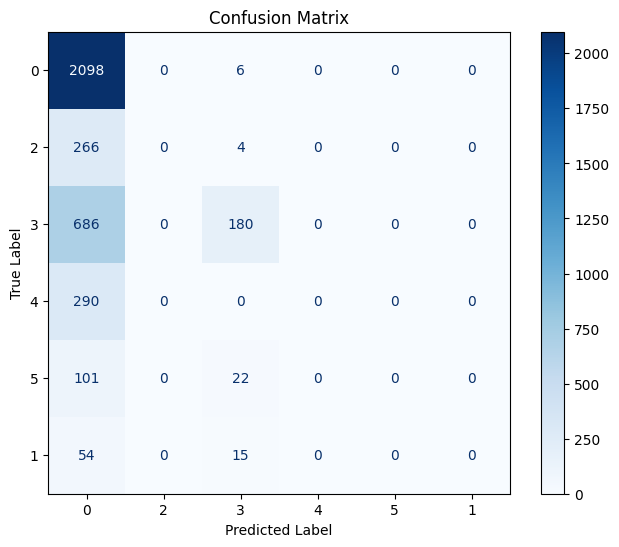

In [15]:
confusion_matrix = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Trainings- und Validationkurve plotten

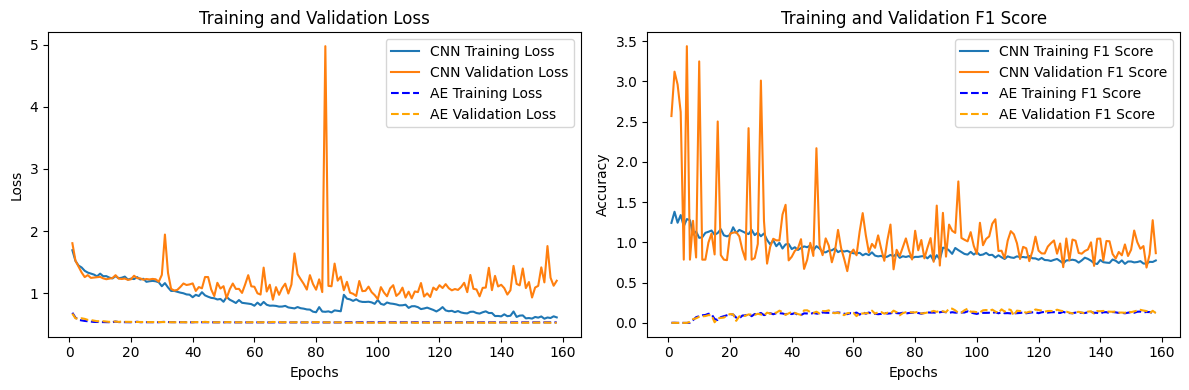

In [18]:
epochs = len(train_losses_cnn)
plt.figure(figsize=(12, 4))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_cnn, label='CNN Training Loss')
plt.plot(range(1, epochs + 1), val_losses_cnn, label='CNN Validation Loss')
plt.plot(range(1, epochs + 1), train_losses_ae, "--", color="blue", label='AE Training Loss')
plt.plot(range(1, epochs + 1), val_losses_ae, "--", color="orange", label='AE Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies_cnn, label='CNN Training F1 Score')
plt.plot(range(1, epochs + 1), val_accuracies_cnn, label='CNN Validation F1 Score')
plt.plot(range(1, epochs + 1), train_accuracies_ae, "--", color="blue", label='AE Training F1 Score')
plt.plot(range(1, epochs + 1), val_accuracies_ae, "--", color="orange", label='AE Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()

In [19]:
print("Unser Modell:")
print(f"CNN Avg. Val Accuracy: {sum(val_accuracies_cnn) / len(val_accuracies_cnn)}")
print(f"CNN Best Val Accuracy: {max(val_accuracies_cnn)}")
print(f"CNN Avg. Test Accuracy: {sum(test_accuracies_cnn) / len(test_accuracies_cnn)}")
print(f"CNN Best Test Accuracy: {max(test_accuracies_cnn)}")
print(f"CNN Avg. Test Loss: {sum(test_losses_cnn) / len(test_losses_cnn)}")
print(f"AE Avg. Val Accuracy: {sum(val_accuracies_ae) / len(val_accuracies_ae)}")
print(f"AE Best Val Accuracy: {max(val_accuracies_ae)}")
print(f"AE Avg. Test Accuracy: {sum(test_accuracies_ae) / len(test_accuracies_ae)}")
print(f"AE Best Test Accuracy: {max(test_accuracies_ae)}")
print(f"AE Avg. Test Loss: {sum(test_losses_ae) / len(test_losses_ae)}")

Unser Modell:
CNN Avg. Val Accuracy: 1.0780754821209968
CNN Best Val Accuracy: 3.438354730606079
CNN Avg. Test Accuracy: 0.6820396482944489
CNN Best Test Accuracy: 0.7280407547950745
CNN Avg. Test Loss: 1.228298544883728
AE Avg. Val Accuracy: 0.12147946550323002
AE Best Val Accuracy: 0.17702777683734894
AE Avg. Test Accuracy: 0.12967944890260696
AE Best Test Accuracy: 0.1388261765241623
AE Avg. Test Loss: 0.5314750075340271
